<a href="https://colab.research.google.com/github/andr3w1699/Intelligent_System_for_Pattern_Recognition/blob/main/Assignement3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignement 3 (ISPR)
Selected assignement:

Assignment 4
DATASET (Airline reviews): https://www.kaggle.com/datasets/khushipitroda/airline-reviews

The dataset contains text of online travel reviews (in Column Review) with an associated Rating (column Overall_Rating). The objective is to train a classifier to predict the rating from the Review text. You are free to choose the model's architecture, but you should describe and justify your design choices.  Train the model and assess it as appropriate in machine learning. You are allowed to preprocess the data however you want (e.g. using pretrained embeddings, dropping some features, just a bag-of-words), but the predictive model must be trained by yourself from scratch (no pretrained predictor).

## Idea for the model architecture and processing pipeline
While doing this assignment I want to compare different sentiment classification models, all based on the use of Deep Learning models built on top of review embeddings.

The general scheme is to tokenize the reviews, map each token in an embedding (using either a pre-trained model or training the embeddings from scratch together with the task-specific network) and then train a classification model to solve the binary classification task of the sentiment(negative, positive).

First, models based on recurrent neural networks (RNN and gated variants(LSTM or GRU) will be implemented, to do this the text sequences will be encoded as embedding sequences, ideally one for each word/tokens that constitutes the review, then a classifier based on RNN will be trained with an appropriate classification head.

Then will be tested another architecture, for each review, rather than having a sequence of embedding (one for each token), we want a **single fixed-dim** embedding vector for each review. This will be obtained by mapping each token of the sentence in the corresponding embedding vector as before, and then somehow pool together (e.g. averaging)  the embeddings of all the words in the review to get a single embedding vector for each review . On top of these fixed-size embeddings, I can use any deep model for non-sequential data/flat vector for the classification task.

As for embeddings, we experiment with both the default embeddings built by Keras during the training process in the Embedding Layer of the model and the pre-trained GloVE embeddings.

If i will have enough time I will experiment a bit with contextual-embedding with the tranformer-based pretrained model Electra:
https://huggingface.co/docs/transformers/main/model_doc/electra

In [1]:
# needed libraries and import
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l2
import re
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Dataset and brief Data Understanding and Preprocessing

In [2]:
# load the dataset Airline_Reviews.csv on colab from local
uploaded = files.upload()

Saving Airline_Reviews.csv to Airline_Reviews.csv


In [4]:
# load the dataset on a Pandas dataframe
df = pd.read_csv('Airline_Reviews.csv')
df.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Airline Name            23171 non-null  object 
 2   Overall_Rating          23171 non-null  object 
 3   Review_Title            23171 non-null  object 
 4   Review Date             23171 non-null  object 
 5   Verified                23171 non-null  bool   
 6   Review                  23171 non-null  object 
 7   Aircraft                7129 non-null   object 
 8   Type Of Traveller       19433 non-null  object 
 9   Seat Type               22075 non-null  object 
 10  Route                   19343 non-null  object 
 11  Date Flown              19417 non-null  object 
 12  Seat Comfort            19016 non-null  float64
 13  Cabin Staff Service     18911 non-null  float64
 14  Food & Beverages        14500 non-null

The columns of the dataset we are interested in are  "Review" that we want to use to predict "Overall_Rating". Other columns that could be useful for our task are the column "Review_Title" which we can concatenate to the full review and then the columns Recommended that contains yes if the overall experience is recommended by the user, not otherwise, that we can use to do some check to clean the dataset.

In [6]:
# see which are the Rating values in column Overall_Rating
print(df['Overall_Rating'].unique())

['9' '1' '8' '2' '3' '5' '6' '7' '4' 'n']


In [7]:
# print the count of each rating values
print(df['Overall_Rating'].value_counts())

Overall_Rating
1    11595
2     2296
9     1768
8     1757
3     1356
7     1192
4      859
n      842
5      830
6      676
Name: count, dtype: int64


In [8]:
# type of elem in column Overall_Rating
print(df['Overall_Rating'].dtype)

object


In [9]:
# check for null values
print(df.isnull().sum())

Unnamed: 0                    0
Airline Name                  0
Overall_Rating                0
Review_Title                  0
Review Date                   0
Verified                      0
Review                        0
Aircraft                  16042
Type Of Traveller          3738
Seat Type                  1096
Route                      3828
Date Flown                 3754
Seat Comfort               4155
Cabin Staff Service        4260
Food & Beverages           8671
Ground Service             4793
Inflight Entertainment    12342
Wifi & Connectivity       17251
Value For Money            1066
Recommended                   0
dtype: int64


In [10]:
# check for duplicated values
duplicates = df[df.duplicated()]
print(f"Total duplicate rows: {len(duplicates)}")

Total duplicate rows: 0


First thing we noticed is that:

1.   The Overall_Rating column takes values ​​from 1 to 9 and there are a bunch of missing values with values 'n' that we can remove
2.   The dataset is very unbalanced w.r.t. to this column since there are much much more low rating values e.g. 1,2.
3.   If we want to perform a binary classification task we need to partition the values ​​from 1 to 9 into two classes, one for negative reviews below a certain threshold and one for positive reviews above another threshold. We may consider to discard records with "neutral" values that are in the middle of these two classes.

In [11]:
# Remove all rows where Overall_Rating is 'n'
df = df[df['Overall_Rating'] != 'n']
print(df['Overall_Rating'].unique())

['9' '1' '8' '2' '3' '5' '6' '7' '4']


In [12]:
df['Overall_Rating'] = df['Overall_Rating'].astype(int)
print(df['Overall_Rating'].dtype)

int64


In [13]:
# Remove neutral reviews
df = df[df['Overall_Rating'] != 5]
print(df['Overall_Rating'].unique())

[9 1 8 2 3 6 7 4]


here we try to clean the dataset by removing those reviews that are not consistent, or at least contradictory, that is, they have a very low rating but are recommended or, on the contrary, they are not recommended despite having a high rating

In [14]:
# rows with low rating but recommended
inconsistent_low = df[(df['Overall_Rating'].astype(int) <= 4) & (df['Recommended'].str.lower() == 'yes')]
print("🤨 Low rating but recommended:")
inconsistent_low[['Overall_Rating', 'Recommended', 'Review']].head()

🤨 Low rating but recommended:


,Overall_Rating,Recommended,Review
15,1,yes,Frankfurt to Ljubljana. Flight was very comf...
23,1,yes,Two very short flights with Adria Airways fr...
31,1,yes,Tallinn to Stockholm with Adria Airways. Cle...
33,1,yes,Two short flights with Adria Airways (Ljublj...
41,1,yes,Excellent flights both ways with Adria Airways...


In [15]:
# how many are these incosistent line?
num_inconsistent_low = len(inconsistent_low)
print(f"Inconsistent (Low Rating, Recommended): {num_inconsistent_low}")

Inconsistent (Low Rating, Recommended): 2434


In [16]:
# rows with high rating but not recommended
inconsistent_high = df[(df['Overall_Rating'].astype(int) >= 6) & (df['Recommended'].str.lower() == 'no')]
print("🤔 High rating but not recommended:")
inconsistent_high[['Overall_Rating', 'Recommended', 'Review']].head()

🤔 High rating but not recommended:


,Overall_Rating,Recommended,Review
135,6,no,Larnaca to Athens. I fly Aegean twice weekly ...
237,6,no,There was nothing wrong with the flight itse...
283,6,no,I had paid $50 in advance (on top of my airf...
403,6,no,One of the best things about AR is that they...
508,8,no,Puerto Escondido to Mexico City on Aeromar. Sm...


In [17]:
num_inconsistent_high = len(inconsistent_high)
print(f"Inconsistent (High Rating, Not Recommended): {num_inconsistent_high}")

Inconsistent (High Rating, Not Recommended): 288


Want to remove this inconsistent line which may affect the performance of the model

In [18]:
# Define boolean masks for inconsistencies
mask_low = (df['Overall_Rating'].astype(int) <= 4) & (df['Recommended'].str.lower() == 'yes')
mask_high = (df['Overall_Rating'].astype(int) >= 6) & (df['Recommended'].str.lower() == 'no')

# Combine the two masks
inconsistent_mask = mask_low | mask_high

print(f"Original size: {len(df)}")

# Drop those rows from df
df = df[~inconsistent_mask].reset_index(drop=True)

print(f"New size after removing inconsistencies: {len(df)}")

Original size: 21499
New size after removing inconsistencies: 18777


In [19]:
# print the new count for each rating values
print(df['Overall_Rating'].value_counts())

Overall_Rating
1    9327
2    2264
9    1759
8    1722
3    1304
7    1130
4     777
6     494
Name: count, dtype: int64


Here some basic pre-processing, that in principle could (or no) help the sentiment classification task

In [20]:
# Concatenate Review_Title with Review at the beginning, remove "" in the Title before concatenating
# The title may provide useful information about the sentiment of the review
df['Review'] = df['Review_Title'].str.strip('"') + ' ' + df['Review']

# Map Overall_Rating to Sentiment
def rating_to_sentiment(rating):
    if rating <= 4:
        return 'Negative'
    elif rating >= 6:
        return 'Positive'

# Apply the function to create the 'Sentiment' column
df['Sentiment'] = df['Overall_Rating'].apply(rating_to_sentiment)

# Convert to lowercase
df['Review'] = df['Review'].apply(lambda x: x.lower())

# Remove special characters (keep only letters, numbers, spaces and also !,?and .)
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s!?.]', '', x))

# View the result
df[['Review', 'Overall_Rating', 'Sentiment']].head()

,Review,Overall_Rating,Sentiment
0,pretty decent airline moroni to moheli. turn...,9,Positive
1,not a good airline moroni to anjouan. it is a...,1,Negative
2,flight was fortunately short anjouan to dzao...,1,Negative
3,i will never fly again with adria please do ...,1,Negative
4,it ruined our last days of holidays do not bo...,1,Negative


# Sentiment Analysis with LSTM Model

The following code demonstrates a sentiment analysis pipeline that handles text preprocessing, model training, and evaluation for a binary sentiment classification task using deep learning, in particular using a **Bidirectional LSTM** model. The approach consists of the following steps:

1. **Tokenization and Padding**:
   - A tokenizer is created to keep the 10,000 most frequent words in the dataset and replace any out-of-vocabulary words with the `<OOV>` token.
   - Each review is converted into a sequence of integers representing words, followed by padding/truncation to ensure uniform sequence length (200 tokens).

2. **Label Encoding**:
   - Sentiment labels (e.g., "positive" and "negative") are encoded into numerical values using a `LabelEncoder`.

3. **Data Splitting**:
   - The dataset is split into training (80%) and testing (20%) sets.
   - Class weights are computed to handle the imbalanced dataset.

4. **Model Definition**:
   - A Sequential model is defined with an **Embedding layer** for word representation, followed by a **Bidirectional LSTM** to capture context from both directions.
   - The model includes a **Dropout** layer for regularization and a **Dense** layer with ReLU activation.
   - The output layer uses a **sigmoid** activation function for binary classification.

5. **Model Training**:
   - The model is compiled using `binary_crossentropy` as the loss function and `adam` as the optimizer.
   - Early stopping is implemented to prevent overfitting by monitoring the validation loss and stopping the training if it doesn't improve for 2 epochs.

6. **Evaluation**:
   - The model is evaluated on the test set, and the test accuracy is printed, as well as other metrics more appropriate to imbalanced learning like precision, recall and F1-score.

In [21]:
# Tokenize and pad
# Initialize a tokenizer that will keep only the 10,000 most frequent words.
# Any word not in the top 10,000 will be replaced with the "<OOV>" (out-of-vocabulary) token.
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
# Fit the tokenizer on the 'Review' column to learn the word frequencies and build the word index.
tokenizer.fit_on_texts(df['Review'])
# Convert each review into a sequence of integers, where each integer represents a word's index.
sequences = tokenizer.texts_to_sequences(df['Review'])
# Pad or truncate each sequence to ensure uniform length (200 tokens).
# Sequences longer than 200 are truncated at the end (post).
# Sequences shorter than 200 are padded with 0s at the beginning by default (can change with padding='post').
padded = pad_sequences(sequences, maxlen=200, truncating='post')

In [22]:
# Encode labels
# Initialize a label encoder to convert categorical sentiment labels (e.g., "positive", "negative") into integers.
label_encoder = LabelEncoder()
# Fit the label encoder on the 'Sentiment' column and transform the labels to numeric values.
labels = label_encoder.fit_transform(df['Sentiment'])

In [23]:
for i in range(5):  # print first 5 examples
    print(f"Review #{i+1}")
    print(f"Padded sequence: {padded[i]}")
    print(f"Label (encoded): {labels[i]}")
    print('-' * 50)

Review #1
Padded sequence: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  483  593   29    1    3    1  670   79
    3   36    6  483  593   29  201  220  889  182  156    4   95    7
  348    4    2   64  635  182 1737  116    6   37  260    8   83  302
  119   51   38   38    5  110  502  194   26   13  133  757    3  447
   34    6  895   11  203    4  143 2717   59    5

so my dataset is made by the feature set, `padded` which is composed by padded token sequences  (shape: num_samples x 200)*  and  `label` the encoded sentiment labels that is the target array, made of integer-encoded sentiment labels (0 and 1).


\* Each of the 200 elements in a sample of padded is an integer index that refers to a specific word in your tokenizer’s vocabulary, and Keras handles the mapping automatically during training via the Embedding layer.

In [24]:
# Split the data into training and test sets
# 20% of the data goes to the test set
# Remember that the dataset is very unbalanced
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [25]:
# Compute class weights to handle imbalanced datasets
class_weights = compute_class_weight(
    # automatically calculate weights based on the frequency of each class.
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a dictionary format required by Keras
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: np.float64(0.6855147864184009), 1: np.float64(1.84760147601476)}


In [26]:
# Define the model
model = Sequential([
    # Embedding layer turns word indices into dense vectors
    # input_dim is the size of the vocabulary
    # output_dim determine the size of the embedding vector
    # input_length is the  fixed length of the input sequences after padding/truncation
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    # Bidirectional LSTM to capture context from both directions
    # kernel_regularize is a regularization term that helps prevent overfitting by penalizing large weights in the network --> classical L2 regularization
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, kernel_regularizer=l2(0.001))),
    # Dropout layer for additional regularization
    Dropout(0.5),
    # Dense layer with ReLU activation
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    # Output layer: sigmoid for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
# binary_crossentropy is the correct loss function for binary classification with a sigmoid output.
# sparse_categorical_crossentropy is used for multi-class classification with softmax output.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # 20% of training data used for validation
    epochs=5,
    batch_size=64,
    class_weight=class_weight_dict,  # Using class weight
    callbacks=[early_stopping]    # Using early stopping
)
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.5932 - loss: 0.7534 - val_accuracy: 0.9042 - val_loss: 0.2974
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9295 - loss: 0.2644 - val_accuracy: 0.9205 - val_loss: 0.2959
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9600 - loss: 0.1555 - val_accuracy: 0.9295 - val_loss: 0.2231
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9689 - loss: 0.1239 - val_accuracy: 0.9281 - val_loss: 0.2361
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9762 - loss: 0.1005 - val_accuracy: 0.9311 - val_loss: 0.2316
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9461 - loss: 0.1876
Test Accuracy: 0.9436


In [27]:
# Predict probabilities (sigmoid output between 0 and 1)
y_pred_probs = model.predict(X_test)
# Convert probabilities to binary class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\nMacro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1-score:  {f1:.4f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.95      0.96      2716
    Positive       0.88      0.92      0.90      1040

    accuracy                           0.94      3756
   macro avg       0.92      0.93      0.93      3756
weighted avg       0.94      0.94      0.94      3756


Macro Precision: 0.9229
Macro Recall:    0.9339
Macro F1-score:  0.9281


In [30]:
# compute and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[2584  132]
 [  87  953]]


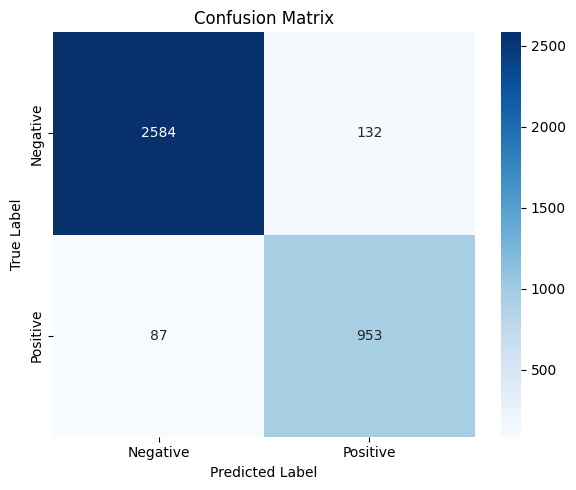

In [31]:
# Optional: Define class labels (e.g., "Negative" and "Positive")
labels = label_encoder.classes_  # or manually: labels = ['Negative', 'Positive']

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Classification Report Analysis

The results discussed were obtained by training the model on the training set, using a validation set for model selection, and testing the model on a separate test set.

The results indicate a strong performance of the model on the sentiment analysis task. Below is a breakdown of the key metrics:

### Precision, Recall, and F1-Score

- **Negative Class**:
  - Precision: **0.97** – The model is highly accurate in predicting negative sentiments, with only 3% of negative predictions being false positives.
  - Recall: **0.95** – The model successfully identifies 95% of actual negative sentiments.
  - F1-Score: **0.96** – The balance between precision and recall for the negative class is strong.

- **Positive Class**:
  - Precision: **0.88** – The model is less precise when predicting positive sentiment, with around 12% false positives.
  - Recall: **0.92** – The model identifies 92% of actual positive sentiments.
  - F1-Score: **0.90** – The positive class has a good F1 score, though not as high as the negative class due to lower precision.

### Overall Performance

- **Accuracy**: **0.94** – The model achieves an overall accuracy of 94%, indicating strong overall classification performance.
- **Macro Average**:
  - Precision: **0.92**, Recall: **0.93**, F1-Score: **0.93** – The macro averages show that the model is fairly balanced in terms of precision and recall across both classes.
- **Weighted Average**:
  - Precision: **0.94**, Recall: **0.94**, F1-Score: **0.94** – The weighted averages are high, reflecting that the model performs well, especially on the larger class (Negative).

### Confusion Matrix

- The confusion matrix reveals the following:
  - **True Negatives (2584)**: The model accurately predicts 2584 negative reviews as negative.
  - **False Positives (132)**: The model incorrectly labels 132 negative reviews as positive.
  - **False Negatives (87)**: The model incorrectly labels 87 positive reviews as negative.
  - **True Positives (953)**: The model correctly predicts 953 positive reviews as positive.

The confusion matrix shows that while the model performs well, it still misclassifies some negative reviews as positive and vice versa. The number of false positives is higher for the negative class, while the false negatives are higher for the positive class, which slightly affects the overall precision and recall for positive sentiment.

### Conclusion

Overall, the model is performing well with high accuracy and strong class-specific F1-scores. However, there is room for improvement, particularly in the positive class, where precision could be improved to reduce false positives. This could be addressed with more data or further tuning of the model.


## Slight modification: using LSTM and not BiLSTM, no bidirectionality
Same setting as before but instead of capturing the context from both direction, use a simple LSTM that acts only in one direction to see if there are some changes in the performances.  

In [32]:
# Define the model
model_LSTM = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    LSTM(64, return_sequences=False, dropout=0.3, kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_LSTM = model_LSTM.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Evaluate
test_loss_LSTM, test_acc_LSTM = model_LSTM.evaluate(X_test, y_test)
print(f"Test Accuracy (LSTM): {test_acc_LSTM:.4f}")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6722 - loss: 0.6400 - val_accuracy: 0.9092 - val_loss: 0.2930
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9354 - loss: 0.2209 - val_accuracy: 0.9301 - val_loss: 0.2173
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9563 - loss: 0.1587 - val_accuracy: 0.9185 - val_loss: 0.2470
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9667 - loss: 0.1223 - val_accuracy: 0.9311 - val_loss: 0.2250
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9392 - loss: 0.1938
Test Accuracy (LSTM): 0.9340


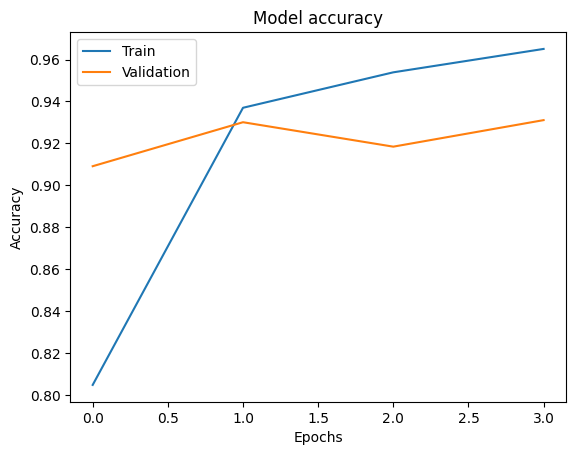

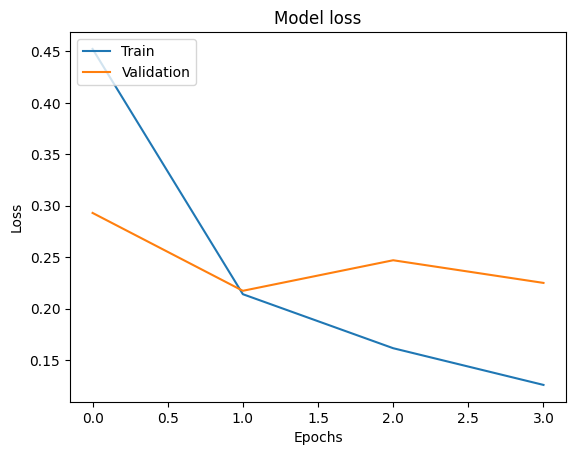

In [33]:
# Plot training & validation accuracy values
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

the use of early stopping let us to avoid overfitting that otherwise woul occurr as you can see in the plot of accuracy and loss in training vs validation

In [34]:
# Predict probabilities (sigmoid output between 0 and 1)
y_pred_probs_LSTM = model_LSTM.predict(X_test)
# Convert probabilities to binary class labels (0 or 1)
y_pred_LSTM = (y_pred_probs_LSTM > 0.5).astype("int32").flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_LSTM, target_names=label_encoder.classes_))

precision_LSTM = precision_score(y_test, y_pred_LSTM, average='macro')
recall_LSTM = recall_score(y_test, y_pred_LSTM, average='macro')
f1_LSTM = f1_score(y_test, y_pred_LSTM, average='macro')

print(f"\nMacro Precision: {precision_LSTM:.4f}")
print(f"Macro Recall:    {recall_LSTM:.4f}")
print(f"Macro F1-score:  {f1_LSTM:.4f}")

cm_LSTM = confusion_matrix(y_test, y_pred_LSTM)
print("\nConfusion Matrix:")
print(cm_LSTM)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.95      0.96      2716
    Positive       0.88      0.90      0.89      1040

    accuracy                           0.94      3756
   macro avg       0.92      0.92      0.92      3756
weighted avg       0.94      0.94      0.94      3756


Macro Precision: 0.9180
Macro Recall:    0.9246
Macro F1-score:  0.9212

Confusion Matrix:
[[2583  133]
 [ 106  934]]


### LSTM vs. BiLSTM – Performance Comparison

Compared to the BiLSTM model, the standard LSTM shows **very similar overall accuracy (94%)**, with only a **slight drop in precision and recall** for the **positive class** (F1-score: 0.89 vs. 0.90). The BiLSTM performs marginally better at capturing contextual nuances, especially for minority class predictions, but the performance difference is minor.


## Simple Vanilla/Elman RNN

Here, a **SimpleRNN** layer replaces LSTM/BiLSTM. Unlike LSTM, SimpleRNN lacks memory gates, making it **less effective at capturing long-term dependencies**, especially in longer sequences. Performance is typically **slightly lower** than LSTM-based models.

To exploer further, one could try:
- **GRU (Gated Recurrent Unit)**: More efficient than LSTM, with similar performance. To implement this is easy just modify the SimpleRNN Layer with a GRU layer.
- **Stacked (multi-layer) RNNs**: To increase model capacity.
- **Transformer-based models**: For stronger context modeling in longer texts.

In [35]:
# Define the model
model_RNN = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    SimpleRNN(64, return_sequences=False, dropout=0.3, kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping, already defined before

# class_weight_dict already defined before

# Train the model
history_RNN = model_RNN.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=7,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss_RNN, test_acc_RNN = model_RNN.evaluate(X_test, y_test)
print(f"Test Accuracy (RNN): {test_acc_RNN:.4f}")

# Predict
y_pred_probs_RNN = model_RNN.predict(X_test)
y_pred_RNN = (y_pred_probs_RNN > 0.5).astype("int32").flatten()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RNN, target_names=label_encoder.classes_))

# Metrics
precision_RNN = precision_score(y_test, y_pred_RNN, average='macro')
recall_RNN = recall_score(y_test, y_pred_RNN, average='macro')
f1_RNN = f1_score(y_test, y_pred_RNN, average='macro')

print(f"\nMacro Precision: {precision_RNN:.4f}")
print(f"Macro Recall:    {recall_RNN:.4f}")
print(f"Macro F1-score:  {f1_RNN:.4f}")

# Confusion Matrix
cm_RNN = confusion_matrix(y_test, y_pred_RNN)
print("\nConfusion Matrix:")
print(cm_RNN)

Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.5943 - loss: 0.7590 - val_accuracy: 0.8433 - val_loss: 0.4945
Epoch 2/7
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8950 - loss: 0.3576 - val_accuracy: 0.7804 - val_loss: 0.5412
Epoch 3/7
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9139 - loss: 0.2916 - val_accuracy: 0.8942 - val_loss: 0.3963
Epoch 4/7
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9375 - loss: 0.2237 - val_accuracy: 0.9008 - val_loss: 0.3326
Epoch 5/7
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9530 - loss: 0.1707 - val_accuracy: 0.8639 - val_loss: 0.3772
Epoch 6/7
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9447 - loss: 0.1937 - val_accuracy: 0.9151 - val_loss: 0.3041
Epoch 7/7
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9633 - loss: 0.1481 - val_accuracy: 0.9138 - val_loss: 0.3120
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9092 - loss: 0.3177
Test Accuracy (RNN): 0.9100
118/118 ━

### Simple RNN – Performance Summary

Compared to LSTM and BiLSTM, the Simple RNN shows **lower recall and F1-score for the positive class**, indicating it struggles more with the minority class. Overall accuracy remains decent (91%), but **context capture is weaker**, confirming the advantage of LSTM-based models for sequential text data.

## Note on the embedding
Embedding layer of Keras, how it works under the hood?
- At the start of training, each word index (from 0 to 9999) is assigned a random vector of size 64 (unless a specific initializer is provided).
- When you feed padded sequences (e.g., [0, 0, 3, 42, 8, ...]) into the network, the embedding layer looks up the corresponding rows in the embedding matrix for each index.

- So a sequence of length 200 becomes a (200, 64) matrix.

- During backpropagation, the embedding vectors are updated just like any other weights in the network.

- This way, words that are important to the classification task get vectors that capture semantic and contextual meaning, based on how they help reduce the loss (like binary cross-entropy in your case).

I want to make a comparison with pretrained embedding e.g GloVe, Word2Vec that use pre-learned word vectors from huge corpora, Often offer better performances when training data is limited and in Keras, you can load them manually and freeze or fine-tune them.

# Model with Pre-trained GloVe Embeddings + LSTM

This approach uses **pre-trained GloVe word vectors** to initialize the embedding layer, allowing the model to leverage rich semantic information from external data. A **Bidirectional LSTM** is used for sequence modeling, combined with **SpatialDropout1D**\* to regularize embeddings. Unlike previous models, the embedding layer is initialized with a fixed embedding matrix built from GloVe and set to **trainable** for fine-tuning.


\* `SpatialDropout1D `is a regularization technique used to prevent overfitting in models that use word embeddings or other sequential inputs, especially before RNNs like LSTMs or GRUs. SpatialDropout1D drops entire 1D feature maps (e.g., entire word embeddings) across the sequence for a given training example.
Consider this:

`["The", "movie", "was", "terrible"]`

With SpatialDropout1D(rate=0.3), in a training step, you might drop the entire embedding for "movie", but keep the rest. This forces the model to not rely too much on any single word.

In [36]:
# Downloading & Unzipping GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-05-08 13:23:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-08 13:23:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-08 13:23:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [37]:
# Load the GloVe embeddings
# This function is designed to load GloVe word embeddings from a text file, (the .txt file containing the pre-trained GloVe embeddings).
# The file path to the GloVe file is passed as an argument to the function.
def load_glove_embeddings(file_path):
    # python dictionary to store word embeddings
    # Key: The word (as a string)
    # Value: The embedding vector (as a NumPy array of floats)
    embeddings_index = {}
    # open Glove file in read mode, ensures the file is properly encoded with UTF-8
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # structure of a line of GloVE file: word value1 value2 value3 ... valueN
            # line is split by spaces into individual parts
            values = line.split()
            # take the word
            word = values[0]
            # take the vector values
            coefs = np.asarray(values[1:], dtype='float32')
            # fill the dictionary
            embeddings_index[word] = coefs
    # return the dictionary
    return embeddings_index

# Load GloVe embeddings (use glove.6B.50d.txt or glove.6B.100d.txt, etc.)
embedding_dim = 200  # or 100, 200, 300 based on the downloaded file
glove_path = f'glove.6B.{embedding_dim}d.txt'
embeddings_index = load_glove_embeddings(glove_path)
print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [38]:
# The word_index is a dictionary created by the Keras tokenizer.
# It contains the words from your training data as keys and their corresponding integer indices as values.
vocab_size = len(tokenizer.word_index) + 1  # number of unique words found in your dataset,  Plus 1 for padding token
# Matrix to Store Word Vectors
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding_matrix with Pre-trained GloVe Vectors
# iterates over every word in the word_index of the tokenizer
for word, index in tokenizer.word_index.items():
    # checks if the word exists in the embeddings_index dictionary
    if word in embeddings_index:
        # f the word is found in embeddings_index,
        # we set the corresponding row in embedding_matrix (at position index)
        # to the word's vector from embeddings_index.
        embedding_matrix[index] = embeddings_index[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (36304, 200)


In [39]:
# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=200,
              weights=[embedding_matrix], trainable=True),
    SpatialDropout1D(0.3),  # <== Good before LSTM
    Bidirectional(LSTM(
        64,
        return_sequences=False,
        dropout=0.3,
        recurrent_dropout=0.3,
        kernel_regularizer=l2(0.001)
    )),
    Dropout(0.2),  # <== slightly earlier dropout before dense
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),  # <== a stronger dropout after dense
    Dense(1, activation='sigmoid')
])
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# early stopping and class weights already defined above

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_split=0.1, batch_size=64, class_weight=class_weight_dict, callbacks=[early_stopping] )

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


212/212 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.6276 - loss: 0.9854 - val_accuracy: 0.8856 - val_loss: 0.4870
Epoch 2/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.8559 - loss: 0.5142 - val_accuracy: 0.8656 - val_loss: 0.5652
Epoch 3/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8871 - loss: 0.4091 - val_accuracy: 0.9308 - val_loss: 0.3129
Epoch 4/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.9177 - loss: 0.3174 - val_accuracy: 0.8955 - val_loss: 0.3763
Epoch 5/5
212/212 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.9283 - loss: 0.2805 - val_accuracy: 0.9355 - val_loss: 0.2640
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - accuracy: 0.9529 - loss: 0.2153
Test Accuracy: 0.9462


In [40]:
# Predict probabilities (sigmoid output between 0 and 1)
y_pred_probs = model.predict(X_test)
# Convert probabilities to binary class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\nMacro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1-score:  {f1:.4f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 271ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.95      0.96      2716
    Positive       0.88      0.94      0.91      1040

    accuracy                           0.95      3756
   macro avg       0.93      0.94      0.93      3756
weighted avg       0.95      0.95      0.95      3756


Macro Precision: 0.9261
Macro Recall:    0.9435
Macro F1-score:  0.9342


In [41]:
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[2579  137]
 [  65  975]]


### Evaluation and Result: GloVe + LSTM Model

The GloVe + LSTM model achieves strong overall performance with **95% accuracy**, showing a **high recall (94%)** and **F1-score (91%)** for the Positive class, which was previously weaker. Compared to earlier models this setup demonstrates significantly better handling of class imbalance and context, with **macro F1 rising to 0.93**. The confusion matrix indicates fewer false negatives (65 vs. 262 in earlier setups), highlighting the combination GLOVE + LSTM’s strength in capturing sequential patterns in text.


# Sentiment Classification with Averaged Word Embeddings and MLP

**Description**:
This model classifies text sentiment using the average of pre-trained word embeddings as fixed-length input vectors to a feedforward neural network (MLP).

In [43]:
# function to compute the average word embedding of a review
def average_embedding(review, tokenizer, embeddings_index, embedding_dim):
    # tokenize the review text into a sequence of word indices
    words = tokenizer.texts_to_sequences([review])[0]  # list of word indices
    # list to store valid word embeddings
    valid_embeddings = []

    # Reverse tokenizer to get word from index
    # dictionary to map word indices back to actual words
    index_word = {v: k for k, v in tokenizer.word_index.items()}

    # For each word index in the review
    for word_idx in words:
        # Get the word
        word = index_word.get(word_idx)
        # If word exists in the pre-trained embeddings add its vector to the list
        if word and word in embeddings_index:
            valid_embeddings.append(embeddings_index[word])

    # return the mean value if exists
    if valid_embeddings:
        return np.mean(valid_embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

# Apply to all reviews in the dataframe
review_vectors = np.array([
    average_embedding(text, tokenizer, embeddings_index, embedding_dim)
    for text in df['Review']
])

print(f"Review vector shape: {review_vectors.shape}")  # Should be (num_reviews, embedding_dim)

# Encode labels
# Convert textual sentiment labels (e.g., "positive", "negative") into integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['Sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    review_vectors, labels, test_size=0.2, random_state=42
)


# Build a simple feedforward classifier
# embedding_dim is as set in the above cells
model = Sequential([
    Dense(128, activation='relu', input_shape=(embedding_dim,), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Get class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dict (Keras requires this format)
class_weights_dict = dict(enumerate(class_weights))

# Now pass it to model.fit()
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Review vector shape: (18777, 200)
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7290 - loss: 0.7322 - val_accuracy: 0.9002 - val_loss: 0.3721
Epoch 2/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8834 - loss: 0.3914 - val_accuracy: 0.9255 - val_loss: 0.2943
Epoch 3/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8985 - loss: 0.3552 - val_accuracy: 0.9222 - val_loss: 0.2922
Epoch 4/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8927 - loss: 0.3418 - val_accuracy: 0.9108 - val_loss: 0.3108
Epoch 5/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9074 - loss: 0.3073 - val_accuracy: 0.9035 - val_loss: 0.3122
Epoch 6/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9067 - loss: 0.3074 - val_accuracy: 0.8663 - val_loss: 0.3720
Epoch 7/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9006 - loss: 0.3041 - val_accuracy: 0.9242 - val_loss: 0.2593
Epoch 8/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9046 - loss: 0.2953 - val_accuracy: 0.9328 - val

In [44]:
# Predict probabilities (sigmoid output between 0 and 1)
y_pred_probs = model.predict(X_test)
# Convert probabilities to binary class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\nMacro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1-score:  {f1:.4f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.95      0.95      2716
    Positive       0.87      0.85      0.86      1040

    accuracy                           0.92      3756
   macro avg       0.91      0.90      0.90      3756
weighted avg       0.92      0.92      0.92      3756


Macro Precision: 0.9083
Macro Recall:    0.9007
Macro F1-score:  0.9044


### Evaluation: Average Embedding + MLP

This approach achieves **92% accuracy**, with solid but slightly lower performance than previous models. The **macro F1-score of 0.90** shows balanced behavior across classes, though the **Positive class recall (85%)** suggests it misses more positive cases than models like LSTM with GLOVE. It's a fast and efficient method, but lacks deeper context modeling.


# ELECTRA + MLP Classifier for Sentiment Analysis

This pipeline uses **ELECTRA-small**, a transformer pretrained with replaced token detection, to extract contextualized `[CLS]` embeddings from each review. These embeddings (size 256) are fed into a **simple MLP classifier** with two hidden layers and dropout regularization. The approach captures rich semantics from the text while remaining computationally efficient. Batched inference is used to speed up embedding extraction. Suitable for high-quality sentence-level representation with moderate resource usage.

\*the choice of Electra over other transformed-based models such as Bert is only due to its particular efficiency especially in the small version

\**Also here the encoder is frozen, no fine tuning is done, only training of the classification head. Because  of time/computational resource scarsity.



In [45]:
from transformers import ElectraTokenizer, TFElectraModel

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/54.5M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


423/423 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7075 - loss: 0.7604 - val_accuracy: 0.8616 - val_loss: 0.4812
Epoch 2/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8546 - loss: 0.4754 - val_accuracy: 0.8703 - val_loss: 0.4171
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8594 - loss: 0.4345 - val_accuracy: 0.8782 - val_loss: 0.3646
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8674 - loss: 0.3924 - val_accuracy: 0.8576 - val_loss: 0.4001
Epoch 5/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8693 - loss: 0.3747 - val_accuracy: 0.8836 - val_loss: 0.3400
Epoch 6/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8778 - loss: 0.3640 - val_accuracy: 0.8776 - val_loss: 0.3377
Epoch 7/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8795 - loss: 0.3440 - val_accuracy: 0.8703 - val_loss: 0.3540
Epoch 8/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8801 - loss: 0.3476 - val_accuracy: 0.8989 - val

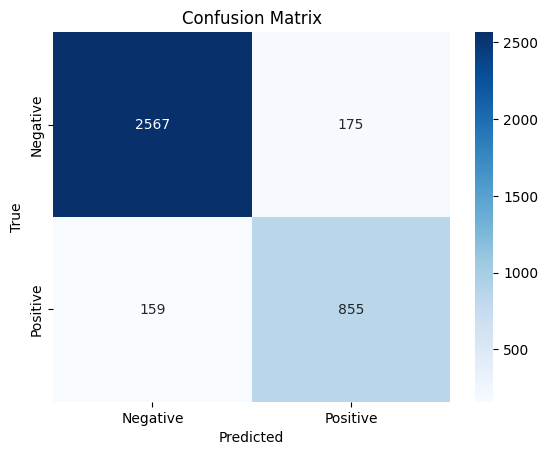

In [46]:
# data already loaded in dataframe df
# here for computational constraint reduce only to sample from the dataset
# actually use all the dataset, but in case...
df_sample = df.sample(frac=1, random_state=42)

# Preprocess: Encode labels as before
labels = label_encoder.fit_transform(df_sample['Sentiment'])  # 0 and 1

# ----------------------------
# Load ELECTRA tokenizer & model
# ----------------------------

model_name = 'google/electra-small-discriminator'
tokenizer = ElectraTokenizer.from_pretrained(model_name)
electra_model = TFElectraModel.from_pretrained(model_name)

# ----------------------------
# Tokenize input texts
# ----------------------------
# Defines a function that takes a list of input texts (`texts`)
# and a batch size for processing in chunks (default is 16).
def get_cls_embeddings(texts, batch_size=16):
    # empty list to store the extracted [CLS] embeddings for all batches
    embeddings = []
    # process the input texts in batches of size 16
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        # tokenize
        inputs = tokenizer(batch_texts, return_tensors='tf', padding=True, truncation=True, max_length=512)
        # pass the tokenize vector through the ELECTRA model
        outputs = electra_model(inputs)
        # Extracts the CLS] token embedding
        cls_tokens = outputs.last_hidden_state[:, 0, :]  # [CLS] embeddings
        embeddings.append(cls_tokens.numpy())
    return np.vstack(embeddings)

# Apply batched inference
X = get_cls_embeddings(df_sample['Review'].tolist(), batch_size=16)

# ----------------------------
# Train-Test Split
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42
)

# ----------------------------
# Build MLP Classifier
# ----------------------------

embedding_dim = X.shape[1]  # Electra hidden size, usually 256 for small

model = Sequential([
    Dense(128, activation='relu', input_shape=(embedding_dim,), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# ----------------------------
# Training with Early Stopping
# ----------------------------

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# ----------------------------
# Evaluate
# ----------------------------

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# ----------------------------
# Evaluation: Accuracy, Confusion Matrix, F1
# ----------------------------

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### Evaluation: ELECTRA + MLP

The ELECTRA + MLP approach achieves a **91% accuracy**, with a **macro F1-score of 0.89**. It performs well overall, especially on the **Negative class**, but the **Positive class shows slightly lower precision and recall (83–84%)**, suggesting room for improvement in detecting positive sentiment.

# Results Summary and Analysis

In this notebook, I explored multiple text classification approaches for sentiment analysis on a labeled dataset of reviews. The goal was to distinguish between **positive** and **negative** sentiments. I implemented and compared the following pipelines:

- **Average Word Embeddings + MLP**: A fast and lightweight approach using pre-trained GloVe vectors averaged per review.  
- **GloVe + Bidirectional LSTM**: Leveraged sequential word embeddings with an LSTM layer for contextual modeling.  
- **Keras Embedding + Simple RNN**: Used trainable embeddings from Keras and a basic RNN to capture sequential dependencies.
- **Keras Embedding + LSTM**: Improved sequential modeling using LSTM instead of a simple RNN.
- **Keras Embedding + Bidirectional LSTM**: Combined trainable embeddings with a BiLSTM for richer context awareness.
- **ELECTRA (Transformer-based) + MLP**: Used contextual [CLS] embeddings from the pre-trained ELECTRA model as input features.

**Performance Comparison (Macro F1-score):**
- **Average + MLP**: 0.90  
- **GloVe + BiLSTM**: 0.93  
- **Keras Embedding + BiLSTM**: 0.93  
- **Keras Embedding + LSTM**: 0.92  
- **Keras Embedding + RNN**: 0.88  
- **ELECTRA + MLP**: 0.89  

The **BiLSTM-based models** (both GloVe and Keras-embedded) yielded the best performance, demonstrating the strength of bidirectional context in understanding sentiment. The **average embeddings** and **RNN models** offered acceptable results with lower resource needs. Interestingly, while **ELECTRA** didn’t outperform the best models in raw F1, its simplicity (fixed embeddings + MLP) and transfer learning potential make it a strong candidate for further fine-tuning.

## Conclusions and Final Considerations

This assignment gave me the opportunity to experiment with several deep learning models studied in the course, applied to the task of text classification. I explored both approaches: learning word embeddings from scratch using Keras's `Embedding` layer, and leveraging pre-trained embeddings—both **static** (like GloVe) and **contextual** (like ELECTRA).

I also gained hands-on experience with the entire NLP pipeline, including text preprocessing, tokenization, and working with GPUs in Colab. Keras proved to be a powerful and accessible framework for rapid prototyping.

This project highlighted the importance of **computational resources** in NLP tasks, especially when using transformer-based encoders—even when used only for inference without fine-tuning. Efficient batching and memory management become critical when working with large models and long input sequences.
